Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 4: Importing and using vector data -- the OGR library
==================================================


## Introduction

The *OGR* library is a companion library to *GDAL* that handles vector data capabilities, including information queryies, file conversions, rasterization of polygon features, polygonization of raster features, and much more. It handles popular formats including the *ESRI Shapefile*, *Keyhole Markup Language*, *PostGIS*, and *SpatiaLite*. For more information on how *OGR* came about and how it relates to *GDAL*, see here: http://trac.osgeo.org/gdal/wiki/FAQGeneral#WhatisthisOGRstuff.

In this tutorial we'll be working with: 
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): `shapely` does things like buffers, unions, intersections, centroids, convex hulls, and lots more.
  * `shapely` is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.
* [Fiona](https://fiona.readthedocs.io/en/latest/): `fiona` does reading and writing data formats.
 * `fiona` is OGR's neat and nimble API for Python programmers. It focuses on reading and writing data in standard Python IO style and relies upon familiar Python types and protocols such as files, dictionaries, mappings, and iterators instead of classes specific to OGR. `fiona` can read and write real-world data using multi-layered GIS formats and zipped virtual file systems and integrates readily with other python GIS packages such as `pyproj`, `Rtree`, and `Shapely`.
* [Descartes](https://bitbucket.org/sgillies/descartes/): a simple library for plotting geometries in `matplotlib`
* [Folium](https://github.com/python-visualization/folium): builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. 
  * Manipulate your data in Python, then visualize it in on a Leaflet map via `folium`. `folium` makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.

In this chapter we will use an *ESRI Shapefile* that contains training data I collected in QGIS for the example image we've been working on.

## Opening an *ESRI Shapefile*

Just like *GDAL*, *OGR* abstracts the file formats so that we can use the same code for any format. It employs the same concept of a *dataset* object which we can gather information from:

In [138]:
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon

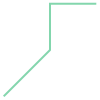

In [72]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

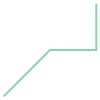

In [73]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

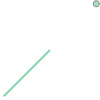

In [74]:
x = b.intersection(a)
x

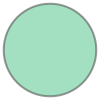

In [75]:
a = Point(1, 1).buffer(1.5)
a

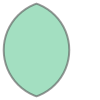

In [76]:
b = Point(2, 1).buffer(1.5)
a.intersection(b)

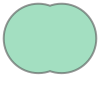

In [77]:
a.union(b)

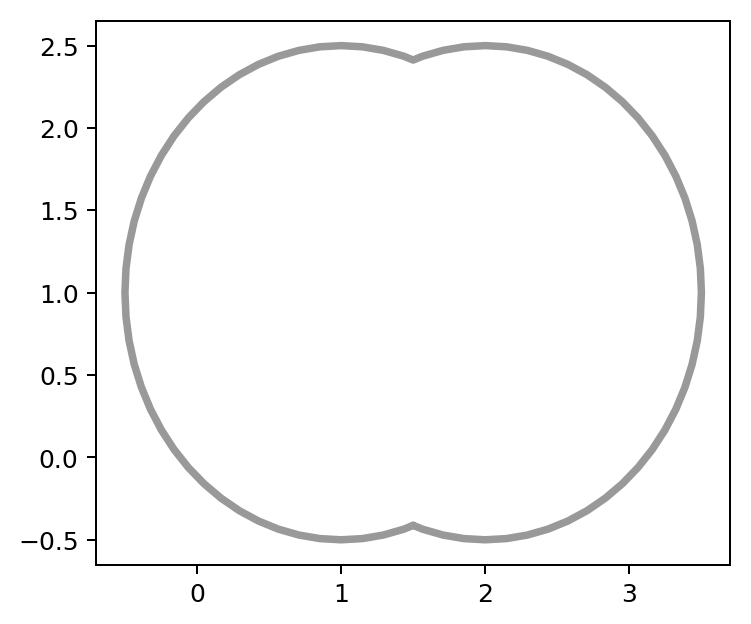

In [96]:
import matplotlib.pyplot as plt # this is python's standard and powerful plotting library
from descartes import PolygonPatch # this is a helpful library for plotting shapely shapes in matplotlib

%matplotlib inline

BLUE = '#6699cc'
GRAY = '#999999'

fig = plt.figure(1, figsize=(10, 4), dpi=180)
ax = fig.add_subplot(121)
x, y = a.union(b).exterior.xy
ax.plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=1)
plt.show()

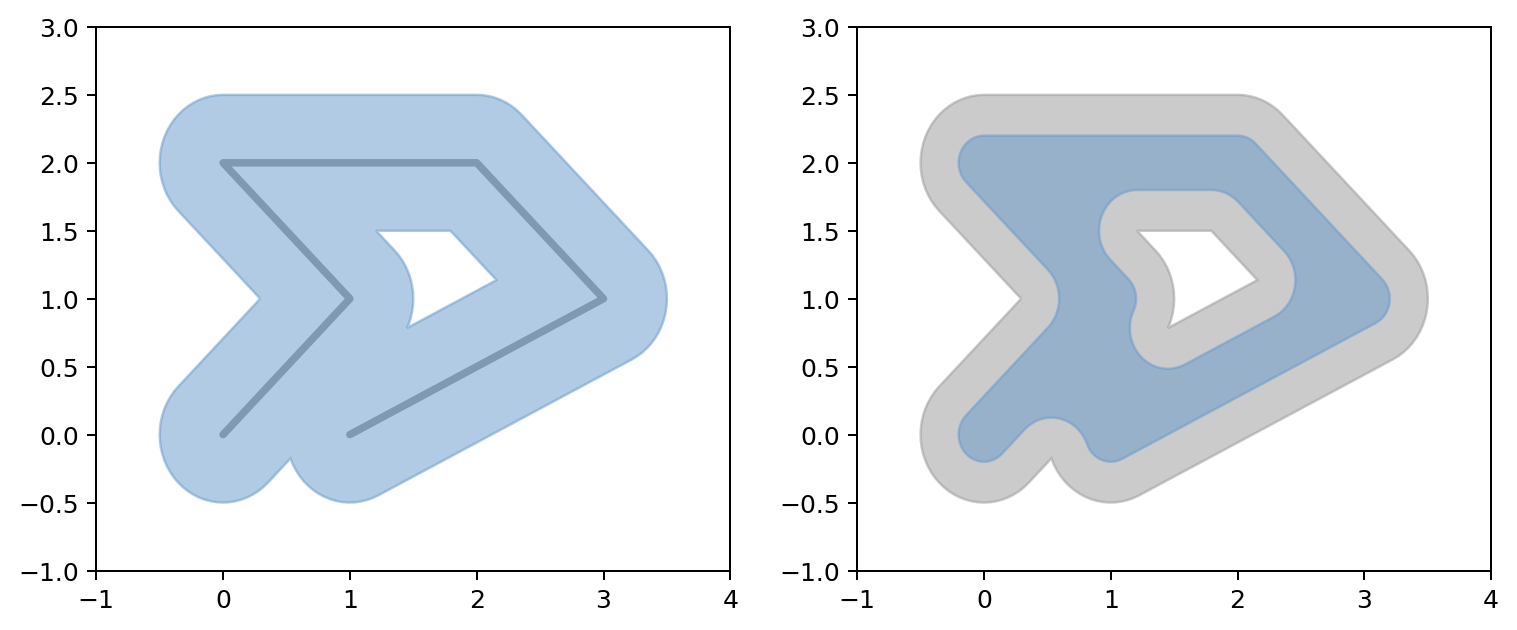

In [105]:
def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=1)

# let's create a line to plot
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

fig = plt.figure(1, figsize=(10, 4), dpi=180)

# Subplot # 1
ax = fig.add_subplot(121)

ax.set_xlim([-1,4])
ax.set_ylim([-1,3])

plot_line(ax, line) # add the line to the plot

dilated = line.buffer(0.5) # create a dilated version of this line - note this creates a polygon
patch1 = PolygonPatch(dilated, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2) # create a PolygonPatch for easy plotting
ax.add_patch(patch1) # add this polygon to the plot

# Subplot # 2
ax = fig.add_subplot(122)

ax.set_xlim([-1,4])
ax.set_ylim([-1,3])

patch2a = PolygonPatch(dilated, fc=GRAY, ec=GRAY, alpha=0.5, zorder=1)
ax.add_patch(patch2a)

eroded = dilated.buffer(-0.3)

# GeoJSON-like data works as well

polygon = eroded.__geo_interface__
patch2b = PolygonPatch(polygon, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(patch2b)

plt.show()

### Using fiona to import shapefiles 

In [22]:
import fiona
# Open the dataset from the file
#shapefile = fiona.open("all_merge.shp")
shapefile = fiona.open('../../example/training_data.shp')
shapefile = fiona.open('../../example/rcr/NERRS_herb_samples_2.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not shapefile:
    print('Error: could not open shapefile')

With our Shapefile read in, we can look at some of its properties:

In [23]:
### Let's get the driver from this file
driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))

### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile[0]['geometry']['type']

### What is the name of the first feature?
feature = shapefile[0]
#print('The layer is named: {n}\n'.format(n=feature))

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

Dataset driver is: ESRI Shapefile

The shapefile has 65 feature(s)

The features's geometry is: Polygon

Layer has 7 fields
Their names are: 
	Classcode
	Classname
	Classvalue
	RED
	GREEN
	BLUE
	Count


In [24]:
# you can get a quick view of all of this
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('Classcode', 'str:254'),
               ('Classname', 'str:254'),
               ('Classvalue', 'int:10'),
               ('RED', 'int:10'),
               ('GREEN', 'int:10'),
               ('BLUE', 'int:10'),
               ('Count', 'int:10')]),
  'geometry': 'Polygon'},
 'crs': {},
 'crs_wkt': ''}

In [25]:
# The shapefile is a list of features, which can be accessed like any python list
feature = shapefile[0]
# The result is a Python dictionary.
feature

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classcode', None),
              ('Classname', 'Sand'),
              ('Classvalue', 2253),
              ('RED', 255),
              ('GREEN', 255),
              ('BLUE', 190),
              ('Count', 740)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(348481.6873325305, 3841625.9444273096),
    (348470.87445113715, 3841610.6314272936),
    (348423.6331232535, 3841637.184122987),
    (348445.40837316494, 3841652.3160573784),
    (348481.6873325305, 3841625.9444273096)]]}}

In [26]:
# As all dictionaries in Python, there are keys and values.
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [27]:
print('id: ', feature['id']) #gives the id
#print feat['properties']['cadmium'] # gives the value of the cadmium attribute

print('geometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
geometry:  {'type': 'Polygon', 'coordinates': [[(348481.6873325305, 3841625.9444273096), (348470.87445113715, 3841610.6314272936), (348423.6331232535, 3841637.184122987), (348445.40837316494, 3841652.3160573784), (348481.6873325305, 3841625.9444273096)]]}


<class 'dict'>
POLYGON ((348481.6873325305 3841625.94442731, 348470.8744511371 3841610.631427294, 348423.6331232535 3841637.184122987, 348445.4083731649 3841652.316057378, 348481.6873325305 3841625.94442731))
<class 'shapely.geometry.polygon.Polygon'>


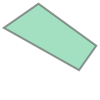

In [28]:
# If you want to transform this geometry into a shapely geometry 
# use the shape function that we imported earlier

print(type(feature['geometry']))

print(shape(feature['geometry']))

print(type(shape(feature['geometry'])))

shape(feature['geometry'])

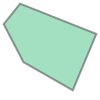

In [29]:
shape(shapefile[1]['geometry'])

In [30]:
shapefile[1]['geometry']

{'type': 'Polygon',
 'coordinates': [[(347202.438243757, 3842389.768595718),
   (347186.38826993946, 3842351.362421192),
   (347152.7702466473, 3842370.5621134043),
   (347139.32864035293, 3842396.4588395525),
   (347150.4861269146, 3842410.384758236),
   (347202.438243757, 3842389.768595718)]]}

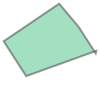

In [31]:
shape(shapefile[29]['geometry'])

## Combining vector files with our raster data

The shapefile is already projected in the same projection that our example raster image is in, so we won't be needing to reproject it. You *could*, however, do so using either the [ogr2ogr](http://www.gdal.org/ogr2ogr.html) command line application, or by [reprojecting the shapefile in Python](http://pcjericks.github.io/py-gdalogr-cookbook/projection.html#reproject-a-layer).

## Tie-in with our Raster dataset

The training data we just opened contains two fields:
+ an ID field (Integer datatype)
+ a class field (String datatype)

Combined with the innate location information of polygons in a Shapefile, fields resemble all that we need to use for pairing labels (i.e., the integer ID and the string description) with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space. 

One (complicated) way of doing this would be to manually loop through each polygon in our vector layer and determine which pixels from our raster are contained within. This approach is exactly what GIS softwares (e.g., ENVI, ArcGIS, QGIS) do when doing pairing rasters with vectors, like when doing zonal statistics.

Another less complicated way would be to use the concept of a Region of Interest (ROI) image where each non-zero pixel value in our ROI image corresponds to a raster representation of a polygon from our vector layer. In the example of our training data, most of the values would be 0 in the rasterized representation because our training data samples are small compared to the entire study area. Because we have assigned an integer ID field to each polygon, we could use these integers to store information about which polygons belong to which pixels. In this case, I have assigned values ranging from 1 - 5 for the classes:

+ 1 - forest
+ 2 - water
+ 3 - herbaceous
+ 4 - barren
+ 5 - urban

To accomplish this rasterization of a vector layer, we could use the GDAL command line utility [gdal_rasterize](http://www.gdal.org/gdal_rasterize.html), but we can stick to pure Python by using the GDAL function [gdal.RasterizeLayer](http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1).

In [32]:
import rasterio
from pyproj import Proj, transform # we will need this to convert UTM to lat, long
import numpy as np
dataset = rasterio.open('../../example/rcr/20171006_rcr_masked.tif')

In [33]:
# check the coordinate system and projection of the raster
dataset.crs
# spatial reference can be checked here: http://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-18n/

CRS({'init': 'epsg:32618'})

In [34]:
# you can get the bounds this way
dataset.bounds

BoundingBox(left=341769.0, bottom=3832617.0, right=361344.0, top=3844659.0)

In [50]:
# or create all four corner points by using 'dataset.transform * (<pixel location>)'
raster_utm_points = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

# Project all longitudes, latitudes
p1 = Proj(dataset.crs)
p2 = Proj(proj='latlong',datum='WGS84') # we want to display on folium using WGS84
# use the pyproj.transform function to convert the positions to longs, lats
longs, lats = transform(p1, p2, np.array(utm_points)[:,0],np.array(utm_points)[:,1])

raster_gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

In [51]:
print('raster bounds in UTM 18N\n', raster_utm_points)
print('raster bounds in lat, lon\n', raster_gps_points)

raster bounds in UTM 18N
 ((341769.0, 3844659.0), (361344.0, 3844659.0), (361344.0, 3832617.0), (341769.0, 3832617.0))
raster bounds in lat, lon
 [(34.73177958279814, -76.72829321203758), (34.734625418828955, -76.51455418988829), (34.62606967415581, -76.51257850231298), (34.62323527036654, -76.72603902549402)]


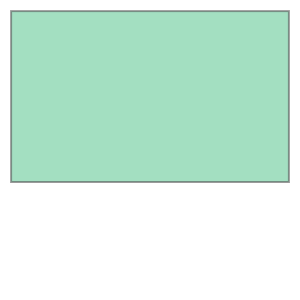

In [52]:
# we can make a simple Shapely shape out of this if we want
raster_geometry = {
    'type' : 'Polygon',
    'coordinates' : [list(raster_utm_points)]     
         }
raster_shape = shape(raster_geometry)
raster_shape

### let's overlay our raster bounds and shapefile features

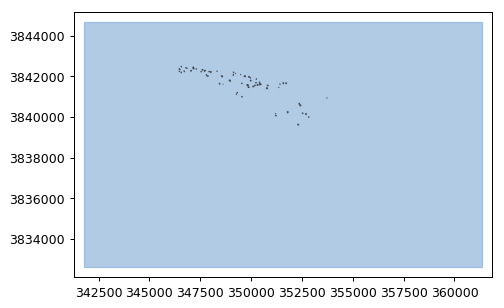

In [53]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt

BLUE = '#6699cc'
GRAY = '#000000'

fig = plt.figure(1, dpi=90)
ax = fig.add_subplot(111)
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(poly1patch)

for feat in shapefile:
    ax.add_patch(PolygonPatch(shape(feat['geometry']), fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

xrange = [int(min(raster_shape.exterior.xy[0]))-500, int(max(raster_shape.exterior.xy[0]))+500]
yrange = [int(min(raster_shape.exterior.xy[1]))-500, int(max(raster_shape.exterior.xy[1]))+500]
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect(1)
plt.show()

### hmm challenging to see, let's zoom in a bit

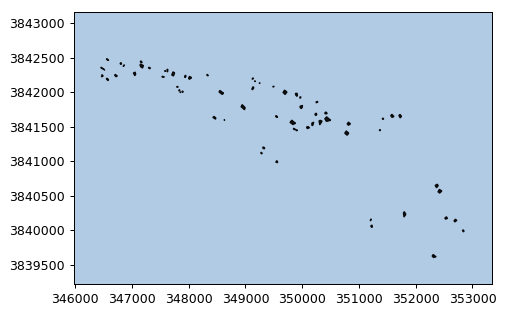

In [54]:
fig = plt.figure(1, dpi=90)
ax = fig.add_subplot(111)
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(poly1patch)

for feat in shapefile:
    ax.add_patch(PolygonPatch(shape(feat['geometry']), fc=GRAY, ec=GRAY, alpha=0.9, zorder=2))

xrange = [int(min(raster_shape.exterior.xy[0]))+4200, int(max(raster_shape.exterior.xy[0]))-8000]
yrange = [int(min(raster_shape.exterior.xy[1]))+6600, int(max(raster_shape.exterior.xy[1]))-1500]
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
#ax.set_aspect(1)
plt.show()

### still not extremely useful, let's make it interactive and add some class labels

In [69]:
import folium # let's make an interactive map using leaflet

m = folium.Map(location=[lats[2], longs[2]], zoom_start=13) # set the map centered around the first point

folium.Polygon(raster_gps_points, 
               tooltip="Raster Bounds", 
               popup='Planet Labs Imagery',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc').add_to(m)

for feat in shapefile:
    feat_geom = shape(feat['geometry'])
    feat_name = feat['properties']['Classname']
    
    try:
        #longs, lats = transform(p1, p2, np.array(utm_points)[:,0],np.array(utm_points)[:,1])
        longs, lats = transform(p1, p2, feat_geom.exterior.xy[0], feat_geom.exterior.xy[1])
        gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

        folium.Polygon(gps_points, 
                   tooltip=feat_name, 
                   color='#000000',
                   fill=True,
                   fill_color='#99999').add_to(m)
    except AttributeError:
        pass
    
#folium.Marker([tl_lat, tl_long], popup='<i>Raster Top Left</i>', tooltip=tooltip).add_to(m)
#folium.PolyLine(points, color="red", weight=100, opacity=1).add_to(m)

m

### that looks much more useful for exploring out dataset

In [296]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
shapefile = gpd.read_file('../../example/rcr/NERRS_herb_samples_2.shp')
# extract the geometry in GeoJSON format
geoms = shapefile.geometry.values # list of shapely geometries
geometry = geoms[2] # shapely geometry
# transform to GeJSON format
from shapely.geometry import mapping
#geoms = [mapping(geoms[1])]
# extract the raster values values within the polygon 
with rasterio.open('../../example/rcr/20171006_rcr_masked.tif') as src:
     out_image, out_transform = mask(src, [geoms[60]], crop=True)

In [294]:
out_image.shape

(4, 15, 20)

In [136]:
shapefile

,Classcode,Classname,Classvalue,RED,GREEN,BLUE,Count,geometry
0,None,Sand,2253,255,255,190,740,"POLYGON ((348481.6873325305 3841625.94442731, ..."
1,None,Forested Wetland,2360,38,115,0,1422,"POLYGON ((347202.438243757 3842389.768595718, ..."
2,None,Scrub-Shrub Wetland,2350,170,255,0,56,"POLYGON ((348636.5240685372 3841599.796723383,..."
3,None,Scrub-Shrub Wetland,2350,170,255,0,161,"POLYGON ((349918.0539562376 3841449.721063673,..."
4,None,Scrub-Shrub Wetland,2350,170,255,0,287,"POLYGON ((349883.7204601169 3841461.460819492,..."
5,None,Forested Wetland,2360,38,115,0,224,"POLYGON ((347571.8113160376 3842222.481347352,..."
6,None,Sand,2253,255,255,190,1278,"POLYGON ((347752.9399173185 3842285.305343091,..."
7,None,Sand,2253,255,255,190,463,"POLYGON ((349343.1530109737 3841196.222640067,..."
8,None,Emergent Wetland,2260,197,0,255,1327,"POLYGON ((351828.6256874055 3840230.735507974,..."
9,None,Emergent Wetland,2260,197,0,255,1426,"POLYGON ((352462.7065634858 3840569.388199177,..."


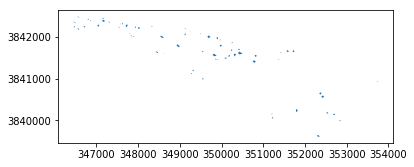

In [216]:
shapefile.plot()

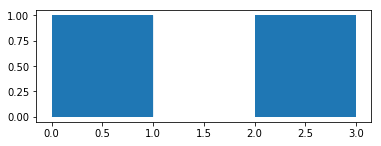

In [141]:
p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
g.plot()

In [149]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
boros.set_index('BoroCode', inplace=True)
boros.sort_index()

,BoroName,Shape_Leng,Shape_Area,geometry
BoroCode,,,,
1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...
3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...


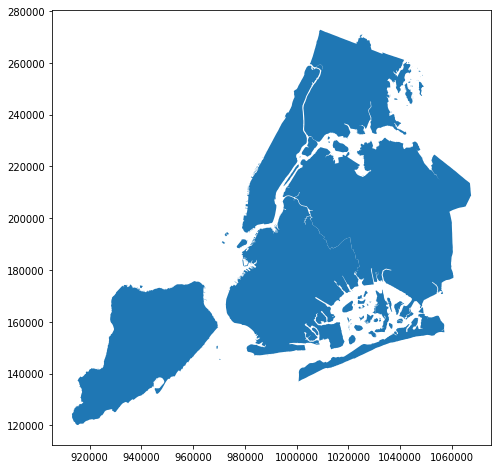

In [153]:
boros.plot(figsize=(8, 8))

In [157]:
# data available from http://www.naturalearthdata.com/downloads/
oceans = gpd.read_file("../../example/ne_110m_ocean.shp")

In [203]:
glaciers = gpd.read_file("../../example/ne_10m_glaciated_areas.shp")

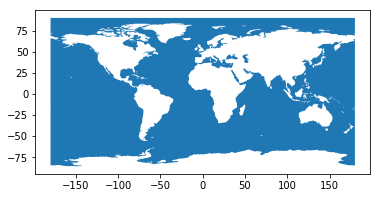

In [159]:
oceans.plot()

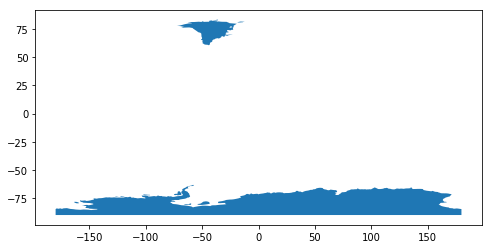

In [164]:
glaciers.plot(figsize=(8, 8))

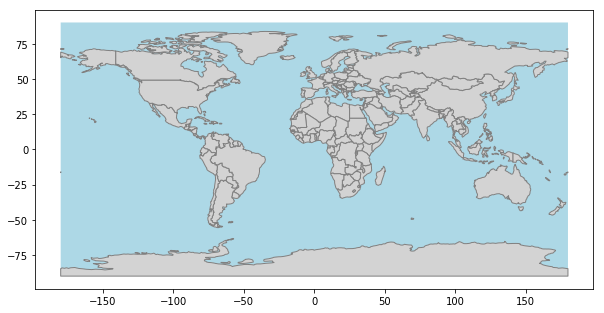

In [222]:
# simple way to plot using the GeoDataFrame plot method to overlay two GeoDataFrames while style customizing the styles for each layer.
world.plot(ax=oceans.plot(figsize=(10, 10), facecolor='lightblue'), facecolor='lightgray', edgecolor='gray');

(-197.99999999999997,
 198.00000000000017,
 -99.00000000000003,
 99.00000000000004)

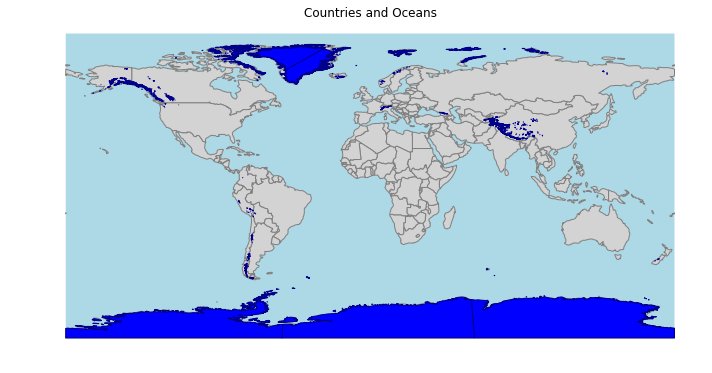

In [219]:
# We can also compose the plot using conventional matplotlib steps and options that give us more control.
# let's add in our glaciers dataset
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_axis_off() 
plt.axis('equal')

In [223]:
# note there are some mismatches between the glacier and land datasets because of the different resolutions

(-155, -145)

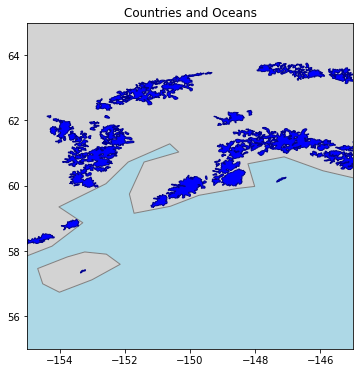

In [215]:
# let's look at Anchorage Alaska at 61.2181° N, 149.9003° W
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Countries and Oceans')
# Other nice categorical color maps (cmap) include 'Set2' and 'Set3'
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_ylim([55, 65])
ax.set_xlim([-155, -145])
#ax.set_axis_off() 
#plt.axis('equal')

In [151]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...


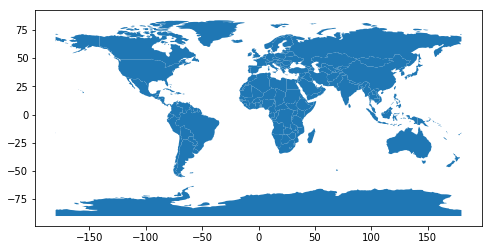

In [152]:
world.plot(figsize=(8, 8))

In [239]:
# with geopandas you can do filtering just like in any pandas dataframe
world[(world.geometry.area > 1000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
6,3802.0,Antarctica,Antarctica,ATA,760.4,(POLYGON ((-59.57209469261153 -80.040178725096...
27,33487208.0,North America,Canada,CAN,1300000.0,(POLYGON ((-63.66449999999998 46.5500099999999...
135,140041247.0,Europe,Russia,RUS,2266000.0,(POLYGON ((143.6480074403629 50.74760040954152...
168,313973000.0,North America,United States,USA,15094000.0,"(POLYGON ((-155.54211 19.08348000000001, -155...."


,geometry,pop_est
continent,,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...,9.932819e+08
Antarctica,(POLYGON ((-159.2081835601977 -79.497059421708...,3.802000e+03
Asia,(POLYGON ((120.7156087586305 -10.2395813940878...,4.085853e+09
Europe,(POLYGON ((-52.55642473001839 2.50470530843705...,7.281312e+08
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1...",5.393510e+08


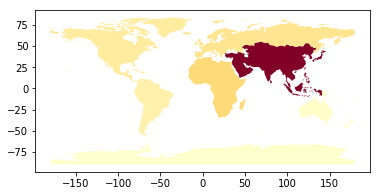

In [258]:
# or more advanced filtering like combining all continents and then mapping by population
world_filtered = world[['continent', 'geometry', 'pop_est']]
continents = world_filtered.dissolve(by='continent', aggfunc='sum')
continents.plot(column = 'pop_est',  cmap='YlOrRd'); # scheme='quantiles',
continents.head()

In [256]:
#gpd.sjoin(world, glaciers, how="inner", op='intersects')

## Read from OGC WFS GeoJSON response into a GeoDataFrame

##### This example drawn from https://geohackweek.github.io/vector/04-geopandas-intro/

Use an Open Geospatial Consortium (OGC) Web Feature Service (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

We won’t go into all details about what’s going on. Suffice it to say that we issue an OGC WFS request for all features from the layer named “oa:goainv” found in a GeoServer instance from NANOOS, requesting the response in GeoJSON format. Then we use the geojson package to “load” the raw response (a GeoJSON string) into a geojson feature object (a dictionary-like object).

The “oa:goainv” layer is a global dataset of monitoring sites and cruises where data relevant to ocean acidification are collected. It’s a work in progress from the Global Ocean Acidification Observation Network (GOA-ON); for additional information see the GOA-ON Data Portal.

In [261]:
import requests
import geojson

wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

Let’s examine the general characteristics of this GeoJSON object, including its __geo_interface__ interface, which we discussed earlier.

In [262]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
578


Now use the from_features constructor method to create a GeoDataFrame directly from the geojson.feature.FeatureCollection object.

In [264]:
wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)

Finally, let’s visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

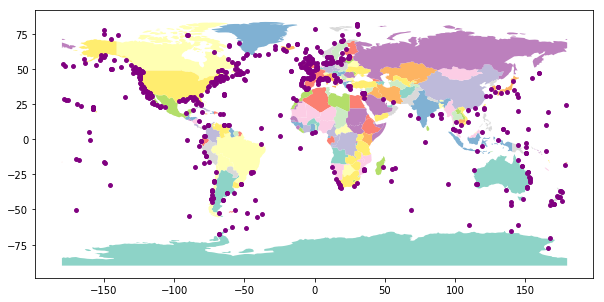

In [282]:
wfs_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
             marker='o', markersize=15,  color='purple');

In [283]:
wfs_gdf.iloc[0]

Oceans                                                    North Atlantic Ocean
additional_organizations                                                      
agency                                      Israeli Ministry of Infrastructure
city                                                                     Haifa
comments                                                                      
comments_about_overlaps                                                       
contact_email                                             jacobs1@ocean.org.il
contact_name                                                   Jacob Silverman
country                                                                 Israel
data_url                                                                      
department                                                                    
deploy_date                                                          01/2011 -
depth_range                                         

## Wrapup

Now that we have our ROI image, we can proceed to use it for pairing our labeled polygons with the matching pixels in our Landsat image to train a classifier for image classification. We continue this step in the next chapter (link to [webpage](chapter_5_classification.html) or [Notebook](chapter_5_classification.ipynb)).